In [1]:
# imports
import numpy as np 
import tensorflow as tf 
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('INFO')
tf.keras.backend.set_floatx('float64')
import matplotlib.pyplot as plt 
import math as m
import seaborn as sn
import GPy
import sys 
import time
from Regressors import * 
from utils import train_step
import pandas as pd 
from itertools import chain
import itertools
import pickle 
from kernels import *
import multiprocessing
from multiprocessing import Pool
import tensorflow_probability as tfp
import contextlib
import functools
import time
import scipy 
from search import *
from changepoint import *
from training import *

In [2]:
# Create false data
Y = np.sin(np.linspace(0,100,100)).reshape(-1,1)
X = np.linspace(0,100,100).reshape(-1, 1)

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

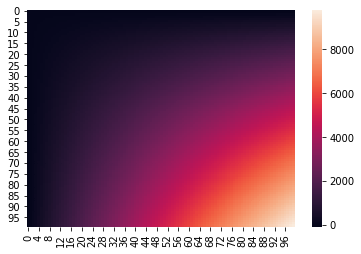

In [9]:
# Compute covariance matrix for linear kernel
cov = LIN(X,X,[1,1,1]).numpy()
sn.heatmap(cov)
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

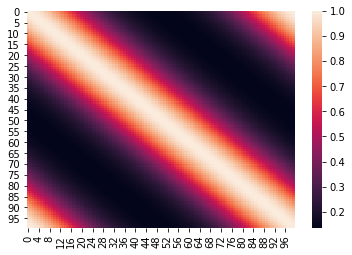

In [10]:
# Compute covariance matrix for Periodic kernel
cov = PER(X,X,[1,1,1]).numpy()
sn.heatmap(cov)
plt.plot

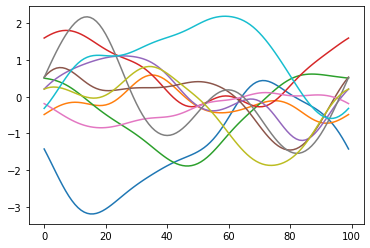

In [21]:
# Get some samples from the posterior and plots 
MEANS = []
for i in range(10) :
    mean,_,_=get_values(np.zeros((cov.shape[0])),cov,nb_samples=1)
    MEANS.append(mean)
for i in range(len(MEANS)) :
    plt.plot(MEANS[i])

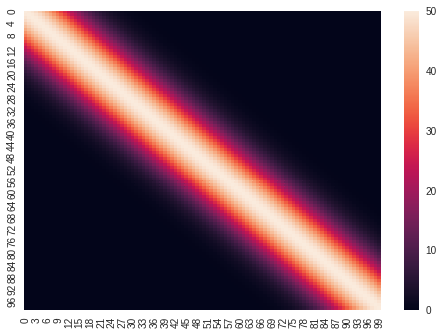

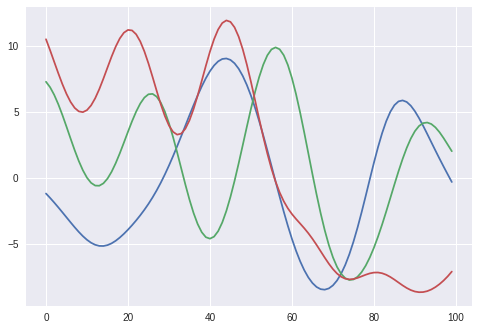

In [47]:
# Compute covariance matrix for Squared Exponential kernel
cov1 = SE(X,X,[10,50]).numpy()
sn.heatmap(cov)
plt.plot
plt.show()
# Get some samples from the posterior and plots 
MEANS = []
for i in range(3) :
    mean,_,_=get_values(np.zeros((cov.shape[0])),cov,nb_samples=1)
    MEANS.append(mean)
for i in range(len(MEANS)) :
    plt.plot(MEANS[i])

Fitting gaussian process
====================

Using scipy lfbgs-b optimizer
-------------------------

In [11]:
# Fit a  model to Y using predifine kernel
X_s = np.linspace(0,len(Y)+60,len(Y)+60).reshape(-1, 1) #we want to predict 60 points
t0 = time.time()
model,kernel = single_model(X,Y,X_s,["+PER"],initialisation_restart=3)  # using the linear kernel
print('time took: {} seconds'.format(time.time()-t0))

==================================================>| * model is ['+PER'] 
 Parameters of  : ['+PER']
   var name               |               value
   periodic_l:0           |           [0.17735099]
   periodic_p:0           |           [6.09145122]
   periodic_sigma:0       |          [15.96270231]
model BIC is [[-98.09707913]]
time took: 7.117807626724243 seconds


 /home/gregoryscafarto/Bureau/gpyflow/utils.py:90: RuntimeWarning:covariance is not positive-semidefinite.


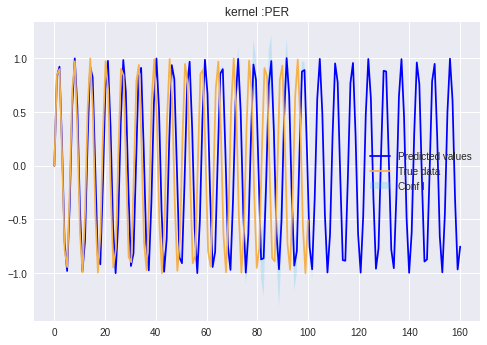

In [12]:
mu,cov = model.predict(X,Y,X_s,kernel)
model.plot(mu,cov,X,Y,X_s,kernel)
plt.show()

In [2]:
# Fitting more complexe data using combinaison of kernels 
X = np.linspace(0,100,100).reshape(-1, 1)
Y = np.sin(X)+X

==================================================>| * model is ['+PER', '+LIN'] 
 Parameters of  : ['+PER', '+LIN']
   var name               |               value
   periodic_l:0           |           [3.13587934]
   periodic_p:0           |           [6.28318532]
   periodic_sigma:0       |          [16.96874844]
   lin_c:0                |           [0.06598008]
   lin_sigmav:0           |           [3.99130362]
   lin_sigmab:0           |           [1.10476871]
model BIC is [[-99.45902898]]
time took: 7.661942958831787 seconds


 /home/gregoryscafarto/Bureau/gpyflow/utils.py:87: RuntimeWarning:covariance is not positive-semidefinite.


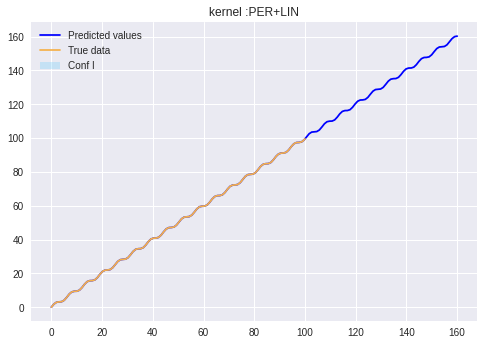

In [49]:
X_s = np.linspace(0,len(Y)+60,len(Y)+60).reshape(-1, 1) #we want to predict 60 points
t0 = time.time()
model,kernel = single_model(X,Y,X_s,["+PER","+LIN"],initialisation_restart=5)   # the kernel is lin+per
print('time took: {} seconds'.format(time.time()-t0))
mu,cov = model.predict(X,Y,X_s,kernel)
model.plot(mu,cov,X,Y,X_s,kernel)
plt.show()

Using stochastic gradient descent optimier
-------------------------

=================================================>| * log likelihood  is : 246695.1506 at iteration : 499 at epoch : 1 / 1 with lr of: 0.11
================================>.................| * log likelihood  is : 102.0330 at iteration : 323 at epoch : 1 / 1 with lr of: 0.11111 Cholesky decomposition was not successful. The input might not be valid.
	 [[node Cholesky (defined at /home/gregoryscafarto/Bureau/gpyflow/utils.py:155) ]] [Op:__forward___call___76737]

Function call stack:
__call__

Cholesky decomposition failed trying with a more important jitter
Cholesky decomposition failed trying with a more important jitter
==================================================>| * model is ['+PER', '+LIN'] 
 Parameters of  : ['+PER', '+LIN']
   var name               |               value
   periodic_l:0           |           [0.04216766]
   periodic_p:0           |           [9.81855763]
   periodic_sigma:0       |           [4.03000685]
   lin_c:0                |          [-0.01662196]


 /home/gregoryscafarto/Bureau/gpyflow/utils.py:87: RuntimeWarning:covariance is not positive-semidefinite.


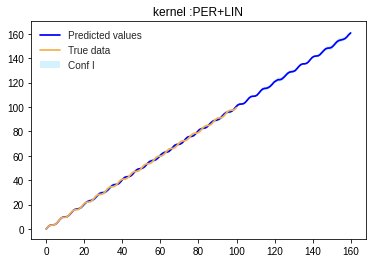

In [3]:
X = np.linspace(0,100,100).reshape(-1, 1)
Y = np.sin(X)+X
X_s = np.linspace(0,len(Y)+60,len(Y)+60).reshape(-1, 1) #we want to predict 60 points
t0 = time.time()
# Training two times using RMSprop optimizer ,500 gradient steps,initialiaze randomly, selecting best of two models
model,kernel = single_model(X,Y,X_s,["+PER","+LIN"],mode="SGD", \
                            nb_restart=1,initialisation_restart=2, \
                            OPTIMIZER=tf.optimizers.RMSprop(0.01),nb_iter=500,verbose=True)
print('time took: {} seconds'.format(time.time()-t0))
mu,cov = model.predict(X,Y,X_s,kernel)
model.plot(mu,cov,X,Y,X_s,kernel)
plt.show()

Training on real data
=================

Using scipy optimizer
----------------

In [38]:
# Loading dataset 
Y = np.array(pd.read_csv("./data/periodic.csv")["x"]).reshape(-1, 1)
X = np.linspace(0,len(Y),len(Y)).reshape(-1,1)
X_s = np.linspace(0,len(Y)+60,len(Y)+60).reshape(-1, 1)

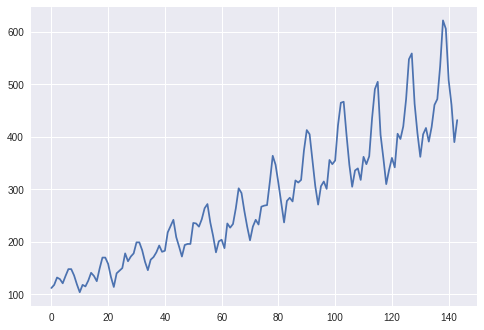

In [37]:
# plotting 
plt.plot(Y)
plt.show()

==================================================>| * model is ['+PER', '+LIN'] 
 Parameters of  : ['+PER', '+LIN']
   var name               |               value
   periodic_l:0           |               [1.e-06]
   periodic_p:0           |          [41.45068393]
   periodic_sigma:0       |      [125894.21185571]
   lin_c:0                |               [1.e-06]
   lin_sigmav:0           |        [6256.93962616]
   lin_sigmab:0           |       [19955.83636988]
model BIC is [[-149.55457949]]
time took: 20.101412296295166 seconds


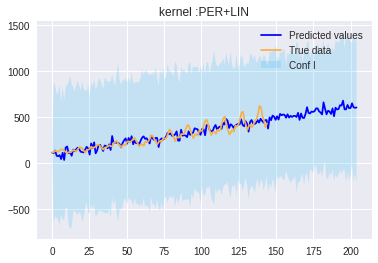

In [32]:
%matplotlib inline
t0 = time.time()
model,kernel = single_model(X,Y,X_s,["+PER","+LIN"], \
                            nb_restart=1,initialisation_restart=20)
print('time took: {} seconds'.format(time.time()-t0))
mu,cov = model.predict(X,Y,X_s,kernel)
model.plot(mu,cov,X,Y,X_s,kernel)
plt.show()

Using stochastic gradient descent 
--------------------------------

=================================================>| * log likelihood  is : 17919757.7978 at iteration : 399 at epoch : 1 / 1 with lr of: 0.1110.1111
=================================================>| * log likelihood  is : 139512526096074.2188 at iteration : 399 at epoch : 1 / 1 with lr of: 0.11
=================================================>| * log likelihood  is : 109983279721429.7656 at iteration : 399 at epoch : 1 / 1 with lr of: 0.11
=================================================>| * log likelihood  is : 147590461138624.1562 at iteration : 399 at epoch : 1 / 1 with lr of: 0.11
==================================================>| * model is ['+PER', '+LIN'] 
 Parameters of  : ['+PER', '+LIN']
   var name               |               value
   periodic_l:0           |           [0.07181828]
   periodic_p:0           |           [4.84012495]
   periodic_sigma:0       |          [10.46863635]
   lin_c:0                |           [4.19601171]
   lin_sigmav:0           |        

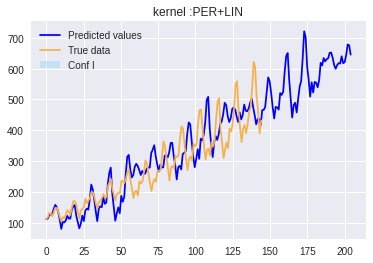

In [39]:
%matplotlib inline
t0 = time.time()
model,kernel = single_model(X,Y,X_s,["+PER","+LIN"],mode="SGD", \
                            nb_restart=1,initialisation_restart=4, \
                            OPTIMIZER=tf.optimizers.RMSprop(0.01),nb_iter=400,verbose=True)
print('time took: {} seconds'.format(time.time()-t0))
mu,cov = model.predict(X,Y,X_s,kernel)
model.plot(mu,cov,X,Y,X_s,kernel)
plt.show()

Comparison with GPy
---------------------------

Optimization restart 1/20, f = 762.3507447388827
Optimization restart 2/20, f = 8105.362848831914
Optimization restart 3/20, f = 765.552430682978
Optimization restart 4/20, f = 810.129210942827
Optimization restart 5/20, f = 717.6378218326272
Optimization restart 6/20, f = 762.3507513316323
Optimization restart 7/20, f = 814.7694621823921
Optimization restart 8/20, f = 808.6995255535692
Optimization restart 9/20, f = 790.561521735958
Optimization restart 10/20, f = 819.064530499275
Optimization restart 11/20, f = 810.34123093981
Optimization restart 12/20, f = 121186.82667622183
Optimization restart 13/20, f = 783.5165690421006
Optimization restart 14/20, f = 762.350742142726
Optimization restart 15/20, f = 868.309494291911
Optimization restart 16/20, f = 642797.1403042519
Optimization restart 17/20, f = 129610.90552689153
Optimization restart 18/20, f = 1487.0870223969403
Optimization restart 19/20, f = 764.1013112330842
Optimization restart 20/20, f = 773.4682429314946
time took: 7.0

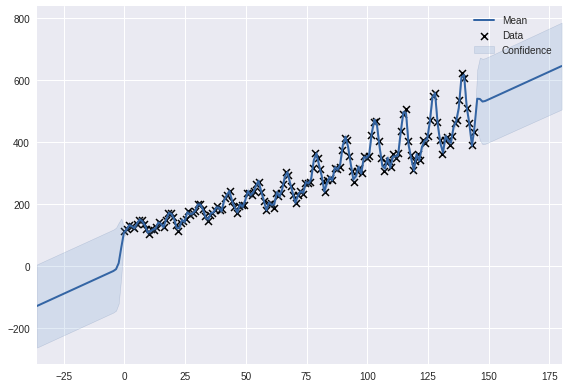

In [33]:
t0 = time.time()
k = GPy.kern.Linear(input_dim=1) + GPy.kern.StdPeriodic(input_dim=1)
m = GPy.models.GPRegression(X, Y, k, normalizer=False)
m.optimize_restarts(20)
print('time took: {} seconds'.format(time.time()-t0))
print(m)
m.plot()
plt.show()

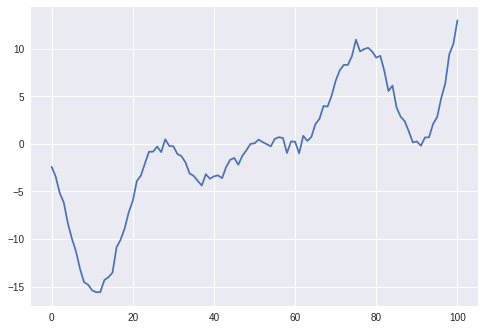

In [40]:
X = np.linspace(-10, 10, 101).reshape(-1,1)
Y = np.array(np.cos( (X - 5) / 2 )**2 * X * 2 + 0.5*np.random.randn(101, 1)).reshape(-1,1)
plt.plot(Y)
plt.show()

Optimization restart 1/20, f = 282.4654907523027
Optimization restart 2/20, f = 169.7184694782793
Optimization restart 3/20, f = 282.46549603320136
Optimization restart 4/20, f = 273.76557748672707
Optimization restart 5/20, f = 286.95190455810723
Optimization restart 6/20, f = 89.47315048902865
Optimization restart 7/20, f = 624.8613549758231
Optimization restart 8/20, f = 282.30931756087836
Optimization restart 9/20, f = 282.08249504756463
Optimization restart 10/20, f = 108.86729742839049
Optimization restart 11/20, f = 282.46553864546894
Optimization restart 12/20, f = 282.08249506451455
Optimization restart 13/20, f = 277.81559273407197
Optimization restart 14/20, f = 94.16293343942772
Optimization restart 15/20, f = 253.59825550344817
Optimization restart 16/20, f = 282.4655469763172
Optimization restart 17/20, f = 282.4198098868548
Optimization restart 18/20, f = 252.53167340359965
Optimization restart 19/20, f = 235.07517817528188
Optimization restart 20/20, f = 282.46550000803

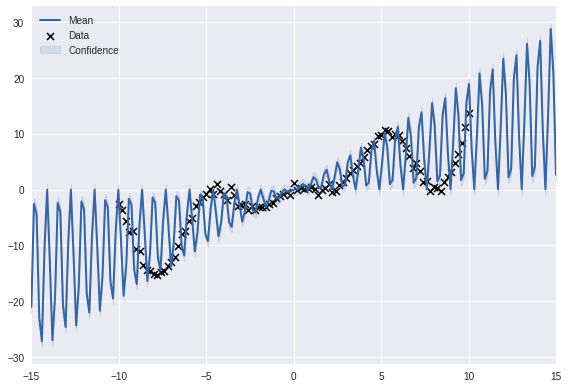

In [23]:
t0 = time.time()
k = GPy.kern.Linear(input_dim=1) * GPy.kern.StdPeriodic(input_dim=1)
m = GPy.models.GPRegression(X, Y, k, normalizer=False)
m.optimize_restarts(20)
print('time took: {} seconds'.format(time.time()-t0))
print(m)
m.plot()
plt.show()

=================================================>| * log likelihood  is : 484.1370 at iteration : 199 at epoch : 1 / 1 with lr of: 0.11of: 0.11
=================================================>| * log likelihood  is : 176.3671 at iteration : 199 at epoch : 1 / 1 with lr of: 0.11110.111
=================================================>| * log likelihood  is : 108.5296 at iteration : 199 at epoch : 1 / 1 with lr of: 0.110.11111
=================================================>| * log likelihood  is : 115.7898 at iteration : 199 at epoch : 1 / 1 with lr of: 0.111111111
=================================================>| * log likelihood  is : 1167.1872 at iteration : 199 at epoch : 1 / 1 with lr of: 0.11110.11
==================================================>| * model is ['+PER', '*LIN'] 
 Parameters of  : ['+PER', '*LIN']
   var name               |               value
   periodic_l:0           |           [0.11359654]
   periodic_p:0           |           [9.37092124]
   periodic_

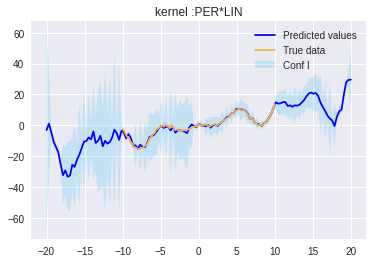

In [24]:
%matplotlib inline
X_s = np.linspace(-20,20,len(Y)+30).reshape(-1, 1)
t0 = time.time()
model,kernel = single_model(X,Y,X_s,["+PER","*LIN"],mode="SGD", \
                            nb_restart=1,initialisation_restart=5, \
                            OPTIMIZER=tf.optimizers.RMSprop(0.1),nb_iter=200,verbose=True)
print('time took: {} seconds'.format(time.time()-t0))
mu,cov = model.predict(X,Y,X_s,kernel)
model.plot(mu,cov,X,Y,X_s,kernel)
plt.show()

==================================================>| * model is ['+PER', '*LIN'] 
 Parameters of  : ['+PER', '*LIN']
   var name               |               value
   periodic_l:0           |               [1.e-06]
   periodic_p:0           |          [25.51089792]
   periodic_sigma:0       |            [1.0106548]
   lin_c:0                |               [1.e-06]
   lin_sigmav:0           |          [36.76337911]
   lin_sigmab:0           |         [124.94243575]
model BIC is [[-106.10277409]]
time took: 26.98652410507202 seconds


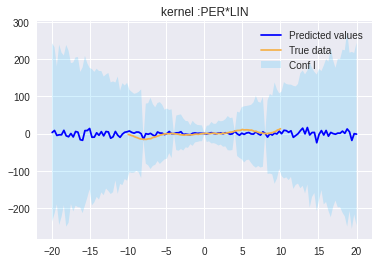

In [41]:
%matplotlib inline
X_s = np.linspace(-20,20,len(Y)+30).reshape(-1, 1)
t0 = time.time()
model,kernel = single_model(X,Y,X_s,["+PER","*LIN"],initialisation_restart=10,verbose=False)
print('time took: {} seconds'.format(time.time()-t0))
mu,cov = model.predict(X,Y,X_s,kernel)
model.plot(mu,cov,X,Y,X_s,kernel)
plt.show()

Search in models space
==================

You chooosed straightforward training
Next combinaison to try : [('*LIN',), ('*SE',), ('*PER',), ('+LIN',), ('+SE',), ('+PER',)]
==>...............................................| * model is ('*LIN',) 
=====>............................................| * model is ('*SE',) 
=======>..........................................| * model is ('*PER',) 
Optimization restart 1/5, f = 808.6995255523954
Optimization restart 2/5, f = 808.6995255547149
Optimization restart 3/5, f = 808.6995255541359
Optimization restart 4/5, f = 808.6995255561726
Optimization restart 5/5, f = 808.6995255524016
error with kernel : +LIN
'numpy.ndarray' object is not callable
==========>.......................................| * model is ('+LIN',) 
Optimization restart 1/5, f = 712.909253902178
Optimization restart 2/5, f = 712.9092499174039
Optimization restart 3/5, f = 712.9092565333001
Optimization restart 4/5, f = 712.909249463692
Optimization restart 5/5, f = 712.9092511351387
error with kernel : +SE
'numpy.nda

Optimization restart 5/5, f = 693.126651000959
=============================================================>| * model is ('+SE', '*PER', '+LIN', '+PER') 
The best model is ['+SE', '*PER', '+LIN', '*PER'] at layer 4
Next combinaison to try : [('+SE', '*PER', '+LIN', '*PER', '*LIN'), ('+SE', '*PER', '+LIN', '*PER', '*SE'), ('+SE', '*PER', '+LIN', '*PER', '*PER'), ('+SE', '*PER', '+LIN', '*PER', '+LIN'), ('+SE', '*PER', '+LIN', '*PER', '+SE'), ('+SE', '*PER', '+LIN', '*PER', '+PER')]
Optimization restart 1/5, f = 764.5713115270707
Optimization restart 2/5, f = 764.5692064999705
Optimization restart 3/5, f = 1896.216170227935
Optimization restart 4/5, f = 736.3757285488825
Optimization restart 5/5, f = 1207.7589053250624
================================================================>| * model is ('+SE', '*PER', '+LIN', '*PER', '*LIN') 
Optimization restart 1/5, f = 2212.6177722344
Optimization restart 2/5, f = 693.576113110397
Optimization restart 3/5, f = 690.3166415652969
Optimization

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f704c17b7c0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f704c17bd00>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f704c17bfa0>]}

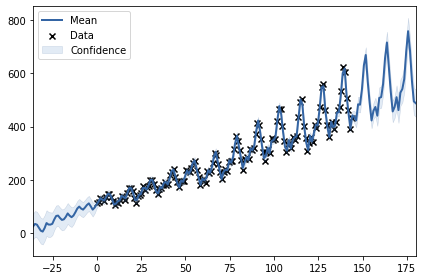

In [10]:
%matplotlib inline
X_s = np.linspace(0,len(Y)+20,len(Y)+20).reshape(-1, 1)
t0 = time.time()
model,kernel = launch_analysis(X,Y,X_s,straigth=True,do_plot=False,depth=6,initialisation_restart=5,GPY=True) #straight parameters == True 
print('time took: {} seconds'.format(time.time()-t0))
print(model)
model.plot()

Optimization restart 1/5, f = 808.6995256761386
Optimization restart 2/5, f = 808.6995255692221
Optimization restart 3/5, f = 808.6995257308688
Optimization restart 4/5, f = 808.6995255788827
Optimization restart 5/5, f = 808.6995255535849
error with kernel : +LIN
'numpy.ndarray' object is not callable
==>...............................................| * model is ('+LIN',) 
Optimization restart 1/5, f = 712.9092494479523
Optimization restart 2/5, f = 749.2400837619722
Optimization restart 3/5, f = 712.9092494676208
Optimization restart 4/5, f = 712.9092494650005
Optimization restart 5/5, f = 712.9092494667977
error with kernel : +SE
'numpy.ndarray' object is not callable
=====>............................................| * model is ('+SE',) 
Optimization restart 1/5, f = 10587.886234483394
Optimization restart 2/5, f = 2492774.393317216
Optimization restart 3/5, f = 761.5628686090912
Optimization restart 4/5, f = 11188.471899151571
Optimization restart 5/5, f = 1064.9329635678969
===

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f5c24054760>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f5c240479d0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f5c24047df0>]}

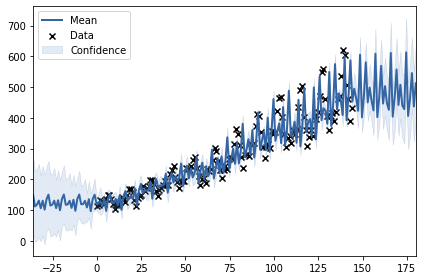

In [4]:
%matplotlib inline
X_s = np.linspace(0,len(Y)+20,len(Y)+20).reshape(-1, 1)
t0 = time.time()
model,kernel = launch_analysis(X,Y,X_s,straigth=False,do_plot=False,depth=3,initialisation_restart=5,GPY=True) #straight parameters == True 
print('time took: {} seconds'.format(time.time()-t0))
print("Model is ",kernel)
print(model)
model.plot()

==>...............................................| * model is ('+LIN',) 
=====>............................................| * model is ('+SE',) 
========>.........................................| * model is ('+PER',) 
===========>......................................| * model is ('+LIN', '*LIN') 
=============>....................................| * model is ('+LIN', '*SE') 
================>.................................| * model is ('+LIN', '*PER') 
===================>..............................| * model is ('+LIN', '+SE') 
======================>...........................| * model is ('+LIN', '+PER') 
=========================>.........................| * model is ('+SE', '*LIN') 
===========================>......................| * model is ('+SE', '*SE') 
==============================>...................| * model is ('+SE', '*PER') 
=================================>................| * model is ('+SE', '+LIN') 
====================================>.............| * mo

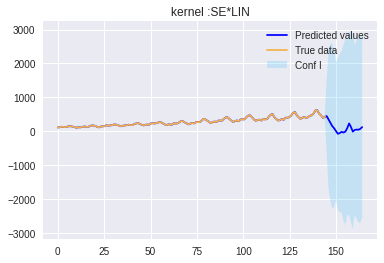

In [18]:
%matplotlib inline
X_s = np.linspace(0,len(Y)+20,len(Y)+20).reshape(-1, 1)
t0 = time.time()
model,kernel = launch_analysis(X,Y,X_s,straigth=False,do_plot=False,depth=3,nb_restart=1,nb_iter=20,verbose=False,initialisation_restart=5,mode="SGD") #straight parameters == True 
print('time took: {} seconds'.format(time.time()-t0))
mu,cov = model.predict(X,Y,X_s,kernel)
model.plot(mu,cov,X,Y,X_s,kernel)
plt.show()

==>...............................................| * model is ('+LIN',) 
=====>............................................| * model is ('+SE',) 
========>.........................................| * model is ('+PER',) 
===========>......................................| * model is ('+LIN', '*LIN') 
=============>....................................| * model is ('+LIN', '*SE') 
================>.................................| * model is ('+LIN', '*PER') 
===================>..............................| * model is ('+LIN', '+SE') 
======================>...........................| * model is ('+LIN', '+PER') 
=========================>.........................| * model is ('+SE', '*LIN') 
===========================>......................| * model is ('+SE', '*SE') 
==============================>...................| * model is ('+SE', '*PER') 
=================================>................| * model is ('+SE', '+LIN') 
====================================>.............| * mo

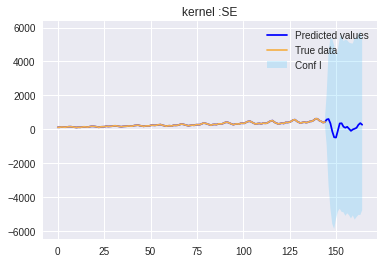

In [20]:
%matplotlib inline
X_s = np.linspace(0,len(Y)+20,len(Y)+20).reshape(-1, 1)
t0 = time.time()
model,kernel = launch_analysis(X,Y,X_s,straigth=False,do_plot=False,depth=3,verbose=False,initialisation_restart=5) #straight parameters == True 
print('time took: {} seconds'.format(time.time()-t0))
mu,cov = model.predict(X,Y,X_s,kernel)
model.plot(mu,cov,X,Y,X_s,kernel)
plt.show()